# Wind turbine fault diagnosis based on ReliefF-PCA and DNN


## Introduction

The wind energy sector has seen significant advancements in recent years, particularly in the monitoring and maintenance of wind turbines. As wind turbines operate in complex environments, understanding the performance and reliability of these systems is crucial. One of the critical aspects of wind turbine management is the early detection and diagnosis of faults, which can lead to costly downtimes and repairs. In this context, the SCADA (Supervisory Control and Data Acquisition) dataset presents valuable insights into the operational status of multiple wind turbines through sensor measurements recorded every 10 seconds.

This dataset includes four turbines: WT2, WT3, WT14, and WT39. Among these, WT2 serves as a baseline, functioning without faults, while WT3, WT14, and WT39 are identified as faulty. Notably, one of the faulty turbines must be excluded from the analysis due to an inconsistent number of variables, which prevents a reliable comparison with the healthy turbine. Additionally, from one of the remaining faulty turbines, the last variable—which represents an extra quality not measured for the other wind turbines—will also be removed. The faults in these turbines are characterized by an initial failure period, followed by a return to normal operation once the issue has been resolved. By analyzing sensor data from these turbines, we can gain insights into the underlying factors contributing to turbine performance and identify the specific sensors that exhibit significant deviations in behavior due to faults.

## Modelling Goal

The primary goal of this project is to utilize multivariate modeling techniques to assess the importance of different sensors in diagnosing faults and to develop methods for filling in missing data within the dataset. This involves calibrating a Principal Component Analysis (PCA) model using data from the healthy turbine (WT2) and creating separate PCA models for the first 20 observations of two selected faulty turbines (WT3 and WT14).

The analysis will focus on identifying sensors that exhibit the most distinct loadings when compared to the healthy turbine. Following this, we will implement Partial Least Squares (PLS) models for the healthy turbine to estimate the values of two critical sensors. The efficacy of these models will be evaluated using test data from one of the faulty turbines. A key aspect of this analysis is to determine whether the regression performance is maintained despite the presence of faults, thereby providing insights into the reliability of predictive models in the context of operational abnormalities in wind turbines.

In [1]:
# importing libraries 
import pandas as pd
# Set pandas options to display maximum rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
# Load the Excel file
file_path = 'data.xlsx'

# Read all sheets into a dictionary of DataFrames
sheets = pd.read_excel(file_path, sheet_name=None)

# Access each DataFrame by the sheet name
WT2_data = sheets['No.2WT']
WT3_data = sheets['No.3']
WT14_data = sheets['No.14WT']
WT39_data = sheets['No.39WT']

## Data Summary 

In [3]:
# data summary 

# Create summaries for each DataFrame and print them
wt_summaries = {
    "WT2 Summary": WT2_data.describe(),
    "WT3 Summary": WT3_data.describe(),
    "WT14 Summary": WT14_data.describe(),
    "WT39 Summary": WT39_data.describe(),
}

# Print the summaries
for title, summary in wt_summaries.items():
    print(f"\n{title}:\n{summary}\n")


WT2 Summary:
                1            2            3            4            5   \
count  1570.000000  1570.000000  1570.000000  1570.000000  1570.000000   
mean     -0.007436    -0.011617    26.311611    29.280290   315.309578   
std       0.045519     0.073934     1.462201     1.631658   117.135733   
min      -0.160518    -0.238556    23.300220    25.748203    96.322975   
25%      -0.042805    -0.065061    25.000227    28.100277   198.148106   
50%      -0.010701    -0.010843    26.900213    29.800323   316.206833   
75%       0.021402     0.043374    27.600269    30.700357   425.548302   
max       0.117713     0.249400    27.700298    31.000391   516.923279   

                6            7            8             9            10  \
count  1570.000000  1570.000000  1570.000000  1.570000e+03  1570.000000   
mean     41.043635    40.906245    41.079840  2.357483e+07   320.622029   
std       2.288937     2.238921     2.233044  3.979615e+02   117.090748   
min      36.498131 



### Breakdown of the Summary Statistics

### WT2 Summary :






1. **Count**: This indicates the total number of non-null entries in each column, which is 1,570 for all columns. This means that there are no missing values in this dataset for WT2.

2. **Mean**: This is the average value of each column, calculated by summing all the values and dividing by the count. For example, the mean of the first column is approximately -0.0074, while for the 3rd column it is about 26.31.

3. **Standard Deviation (std)**: This measures the amount of variation or dispersion of the values in each column. A higher standard deviation indicates that the values are spread out over a wider range. For example, the standard deviation for the 5th column is approximately 117.14, suggesting significant variability in the measurements.

4. **Minimum (min)**: This is the smallest value in each column. For instance, the minimum value in the 5th column is approximately 96.32.

5. **25th Percentile (25%)**: This value indicates that 25% of the data falls below this point. For example, in the 5th column, 25% of the measurements are below approximately 198.15.

6. **50th Percentile (Median, 50%)**: This is the middle value when the data is sorted. For the 5th column, the median is approximately 316.21, indicating that half of the values are below this point.

7. **75th Percentile (75%)**: This indicates that 75% of the data falls below this point. For the 5th column, this value is approximately 425.55.

8. **Maximum (max)**: This is the largest value in each column. For instance, the maximum value in the 5th column is approximately 516.92.

### Column-wise Observations

- **Columns 1 and 2**: Both have similar means and standard deviations, with values around -0.007 and -0.012, indicating slight negative measurements.

- **Columns 3 to 5**: These columns appear to represent significant measurements related to the turbine's operational parameters (e.g., temperature, pressure, etc.), with values showing a narrower range compared to the first two columns.

- **Columns 6 to 16**: These seem to relate to various turbine operational characteristics. The mean values suggest that these measurements fluctuate within certain operational norms.

- **Columns 17 to 28**: These last sets of columns have varying mean values and standard deviations, reflecting the diverse sensor data collectedy turbines and assess model performance.columns, feel free to ask!

### WT3 Summary 



**Count**: This indicates the total number of non-null entries in each column, which is 698 for all columns. This means that there are no missing values in this dataset for WT3.

**Mean**: This is the average value of each column, calculated by summing all the values and dividing by the count. For example, the mean of the first column is 0.0, while for the second column, it is approximately 49.99.

**Standard Deviation (std)**: This measures the amount of variation or dispersion of the values in each column. A higher standard deviation indicates that the values are spread out over a wider range. For example, the standard deviation for the sixth column is approximately 126.48, suggesting significant variability in the measurements.

**Minimum (min)**: This is the smallest value in each column. For instance, the minimum value in the fourth column is approximately -9.16.

**25th Percentile (25%)**: This value indicates that 25% of the data falls below this point. For example, in the fourth column, 25% of the measurements are below approximately 4.82.

**50th Percentile (Median, 50%)**: This is the middle value when the data is sorted. For the fourth column, the median is approximately 13.16, indicating that half of the values are below this point.

**75th Percentile (75%)**: This indicates that 75% of the data falls below this point. For the fourth column, this value is approximately 21.04.

**Maximum (max)**: This is the largest value in each column. For instance, the maximum value in the fourth column is approximately 45.67.

### Additional Column Insights

- **Columns with constant values**: The first column shows a count of 698 with a mean of 0.0, indicating it contains constant values.
- **Columns with binary-like data**: The second column has a mean of approximately 49.99, showing limited variation as indicated by a low standard deviation of 0.03.
- **Data ranges**: Columns such as the 6th show significant variation (std = 126.48) and a maximum value of approximately 359.42, suggesting diverse observations.

This structured explanation provides a clear understanding of each statistical measure, along with specific examples from the dataset for clarity. If you need further analysis or details on specific columns, feel free to ask!set.

### Feature-Specific Statistics

1. **Columns 1 to 6:**
   - **Column 1:** All values are 0.0, indicating that this feature may be a constant.
   - **Column 2:** The mean is approximately 49.99 with a very small standard deviation (0.03), suggesting that the values are tightly clustered around the mean.
   - **Column 3:** The values are constant at approximately 0.044, with no variation (std = 8.33e-17).
   - **Columns 4 and 5:** These columns have a wider range of values, with means of around 13.46 and 12.32, respectively, and standard deviations indicating some variability.
   - **Column 6:** Shows a high mean (67.31) and significant variation (std = 126.48), indicating a wide range of values.

2. **Columns 7 to 13:**
   - **Column 7:** The mean is approximately 88.99 with a low standard deviation (0.0009), showing little variability.
   - **Columns 8 to 10:** All values are constant (0.0, 50.0, and 89.0), suggesting these might be categorical or fixed-value features.
   - **Columns 11 to 13:** Feature small variations in their values with means near zero, suggesting they might represent small deviations from a norm.

3. **Columns 14 to 19:**
   - **Column 14:** Shows a mean around 0.015 with a low standard deviation (0.007), indicating small variations.
   - **Column 15:** A negative mean (-0.0098) indicates a tendency towards lower values, but with variability.
   - **Columns 16 to 19:** These features have higher variability and mean values, indicating a wider distribution of data points.

4. **Columns 20 to 31:**
   - Features like **Columns 20-24** show relatively higher means (around 38-41) with moderate variability.
   - **Column 26:** Negative mean (-0.15) indicates a potential trend towards lower values.
   - **Column 27:** Also shows a negative mean (-0.33) with a high standard deviation, indicating a diverse range of values.
   - **Columns 28 to 31:** Exhibit consistent values (mostly constant around 849.0), but Column 31 has a negative mean (-5.77), suggesting some negative trends in the dataset.

### General Observations
- **Range:** Features show different ranges, from constant values (indicating categorical data) to features with significant variability.
- **Skewness:** Some features (like Columns 1, 3, 8, 9, and 10) show no variability and may not provide meaningful information for modeling. Others indicate potential trends or distributions worth further investigation.
- **Data Quality:** The absence of missing values suggests good data quality, but constant features should data trends and identify any outliers.

### WT14 Summary
**Count**: This indicates the total number of non-null entries in each column, which is 686 for all columns. This means that there are no missing values in this dataset for WT14.

**Mean**: This is the average value of each column, calculated by summing all the values and dividing by the count. For example, the mean of the first column is approximately -0.0094, while for the third column, it is about 50.85.

**Standard Deviation (std)**: This measures the amount of variation or dispersion of the values in each column. A higher standard deviation indicates that the values are spread out over a wider range. For example, the standard deviation for the fifth column is approximately 215.40, suggesting significant variability in the measurements.

**Minimum (min)**: This is the smallest value in each column. For instance, the minimum value in the fifth column is approximately 0.0219.

**25th Percentile (25%)**: This value indicates that 25% of the data falls below this point. For example, in the fifth column, 25% of the measurements are below approximately 0.0219.

**50th Percentile (Median, 50%)**: This is the middle value when the data is sorted. For the fifth column, the median is approximately 0.0326, indicating that half of the values are below this point.

**75th Percentile (75%)**: This indicates that 75% of the data falls below this point. For the fifth column, this value is approximately 427.94.

**Maximum (max)**: This is the largest value in each column. For instance, the maximum value in the fifth column is approximately 1021.72.



### Breakdown of Variables

1. **Columns 1 & 2**: 
   - Mean values are close to zero, indicating they might represent normalized data or changes from a baseline.
   - The standard deviations are relatively low, suggesting less variability.

2. **Columns 3 to 5**: 
   - These columns have higher means and standard deviations, indicating they may represent larger quantities or measurements.
   - The ranges (min to max) show considerable variability, particularly in column 5.

3. **Columns 6 to 10**: 
   - These also have larger means and standard deviations, especially columns 8 and 10, suggesting they may represent quantities related to measurements or counts.

4. **Columns 11 to 27**: 
   - Many columns exhibit high variability, especially column 11, which has a high maximum value and a large standard deviation, indicating a wide range of values.
   - Column 15 has a maximum of 849 but a low standard deviation, suggesting most values are clustered around the mean.

5. **Columns 22 to 27**: 
   - These columns show smaller means compared to previous ones, indicating these might represent more categorical or scaled measurements, as evidenced by lower max values.

### Insights

- **Trends**: The negative means in some columns (1, 2, and 14) could suggest a general decrease or loss in the measured phenomenon.
- **Variability**: High standard deviations in columns 3, 5, 11, and 10 indicate diverse responses or measures across the dataset, possibly indicating different conditions or groups within the data.
- **Distribution**: The quartiles and median values can help infer the distribution shape; for example, if the median is closer to the 25th percentile, the data might be positively skewed.

## Number of Rows and Columns in Each Dataframe

In [4]:


WT2_data = sheets['No.2WT']
WT3_data = sheets['No.3']
WT14_data = sheets['No.14WT']
WT39_data = sheets['No.39WT']

print("Shape of WT2 DataFrame:", WT2_data.shape)
print("Shape of WT3 DataFrame:", WT3_data.shape)
print("Shape of WT14 DataFrame:", WT14_data.shape)
print("Shape of WT39 DataFrame:", WT39_data.shape)


Shape of WT2 DataFrame: (1570, 28)
Shape of WT3 DataFrame: (698, 31)
Shape of WT14 DataFrame: (686, 27)
Shape of WT39 DataFrame: (1405, 27)


### Dropping the Faulty Turbine From Our Analysis
We need to drop one faulty turbine from our analysis which have completely different number of variables. We got this hint in the dataset document. According to the document, WT3 needs to be dropped from our analysis because it has 31 columns where others have 27 columns. We will not work with this dataframe

### Removing the last column of WT2
According to the data hint, it is also mentioned that one	variable	needs	to	be	dropped from the remaining turbines. We will remove the	last	
variabl),	which	represents	an	extra	quality	not	measured	for	the	other	win 
turbines.

In [5]:
WT2_data = WT2_data.iloc[:, :-1]  # This removes the last column

# Print the shapes of the cleaned DataFrames
print("Shape of cleaned WT2 DataFrame:", WT2_data.shape)

Shape of cleaned WT2 DataFrame: (1570, 27)


Now all the turbine data have 27 variables.

## Challenges of the data
Now we will identify the challenges of the data that we have. The first challenge is that we do not know the meaning of the variables. Now lets find out other challenges like missing values or any other inconsistencies

In [6]:



# Function to check for missing values and inconsistencies
def check_data_integrity(df, name):
    print(f"Checking data integrity for {name}:")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values in each column:")
    print(missing_values[missing_values > 0])
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nTotal duplicates: {duplicates}")
    
    # Check data types
    print("\nData types:")
    print(df.dtypes)

    print("\n" + "="*40 + "\n")

    

# Check each DataFrame
check_data_integrity(WT2_data, "WT2_data")
check_data_integrity(WT14_data, "WT14_data")
check_data_integrity(WT39_data, "WT39_data")


Checking data integrity for WT2_data:
Missing values in each column:
Series([], dtype: int64)

Total duplicates: 0

Data types:
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9       int64
10    float64
11    float64
12      int64
13    float64
14      int64
15      int64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
dtype: object


Checking data integrity for WT14_data:
Missing values in each column:
9    1
dtype: int64

Total duplicates: 0

Data types:
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12      int64
13    float64
14    float64
15      int64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26  

There there is only one missing value in column 9 of WT14. Other than that we have no duplicate values.
Although we know they are time series data, we can not confrim whether they are synchronized or not because we do not have timestamp columns.

## Data Distributions of All Variables


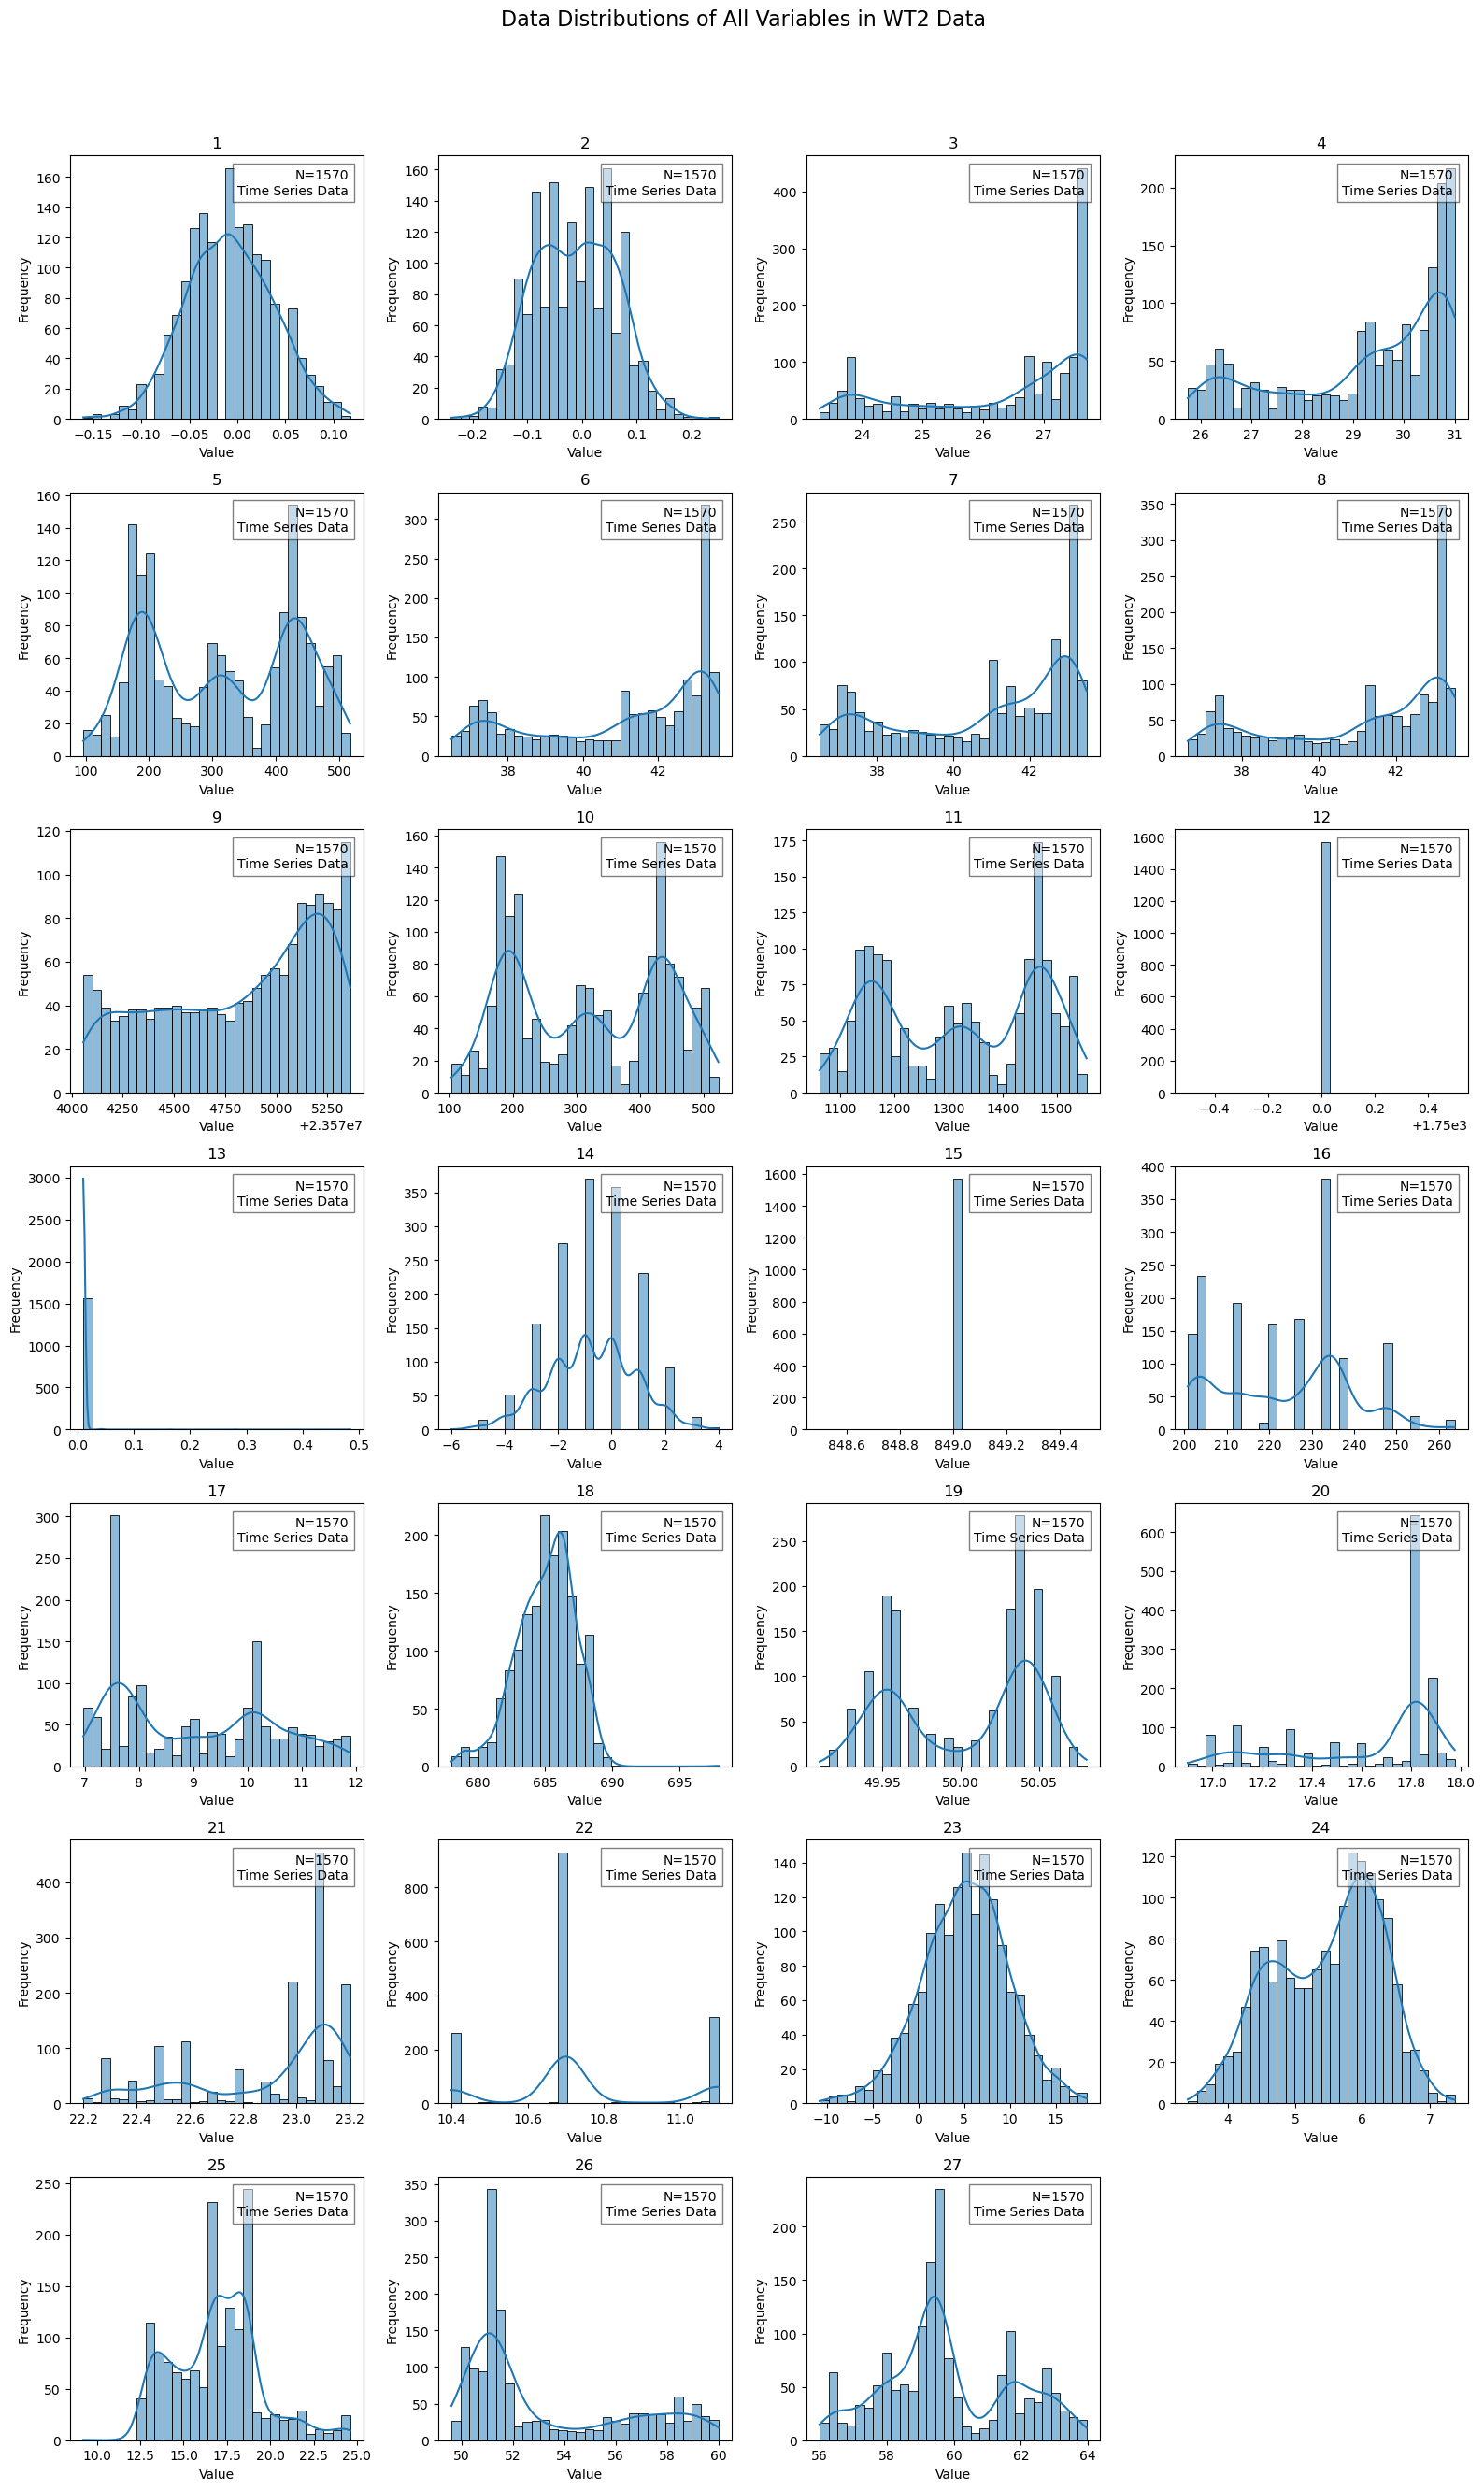

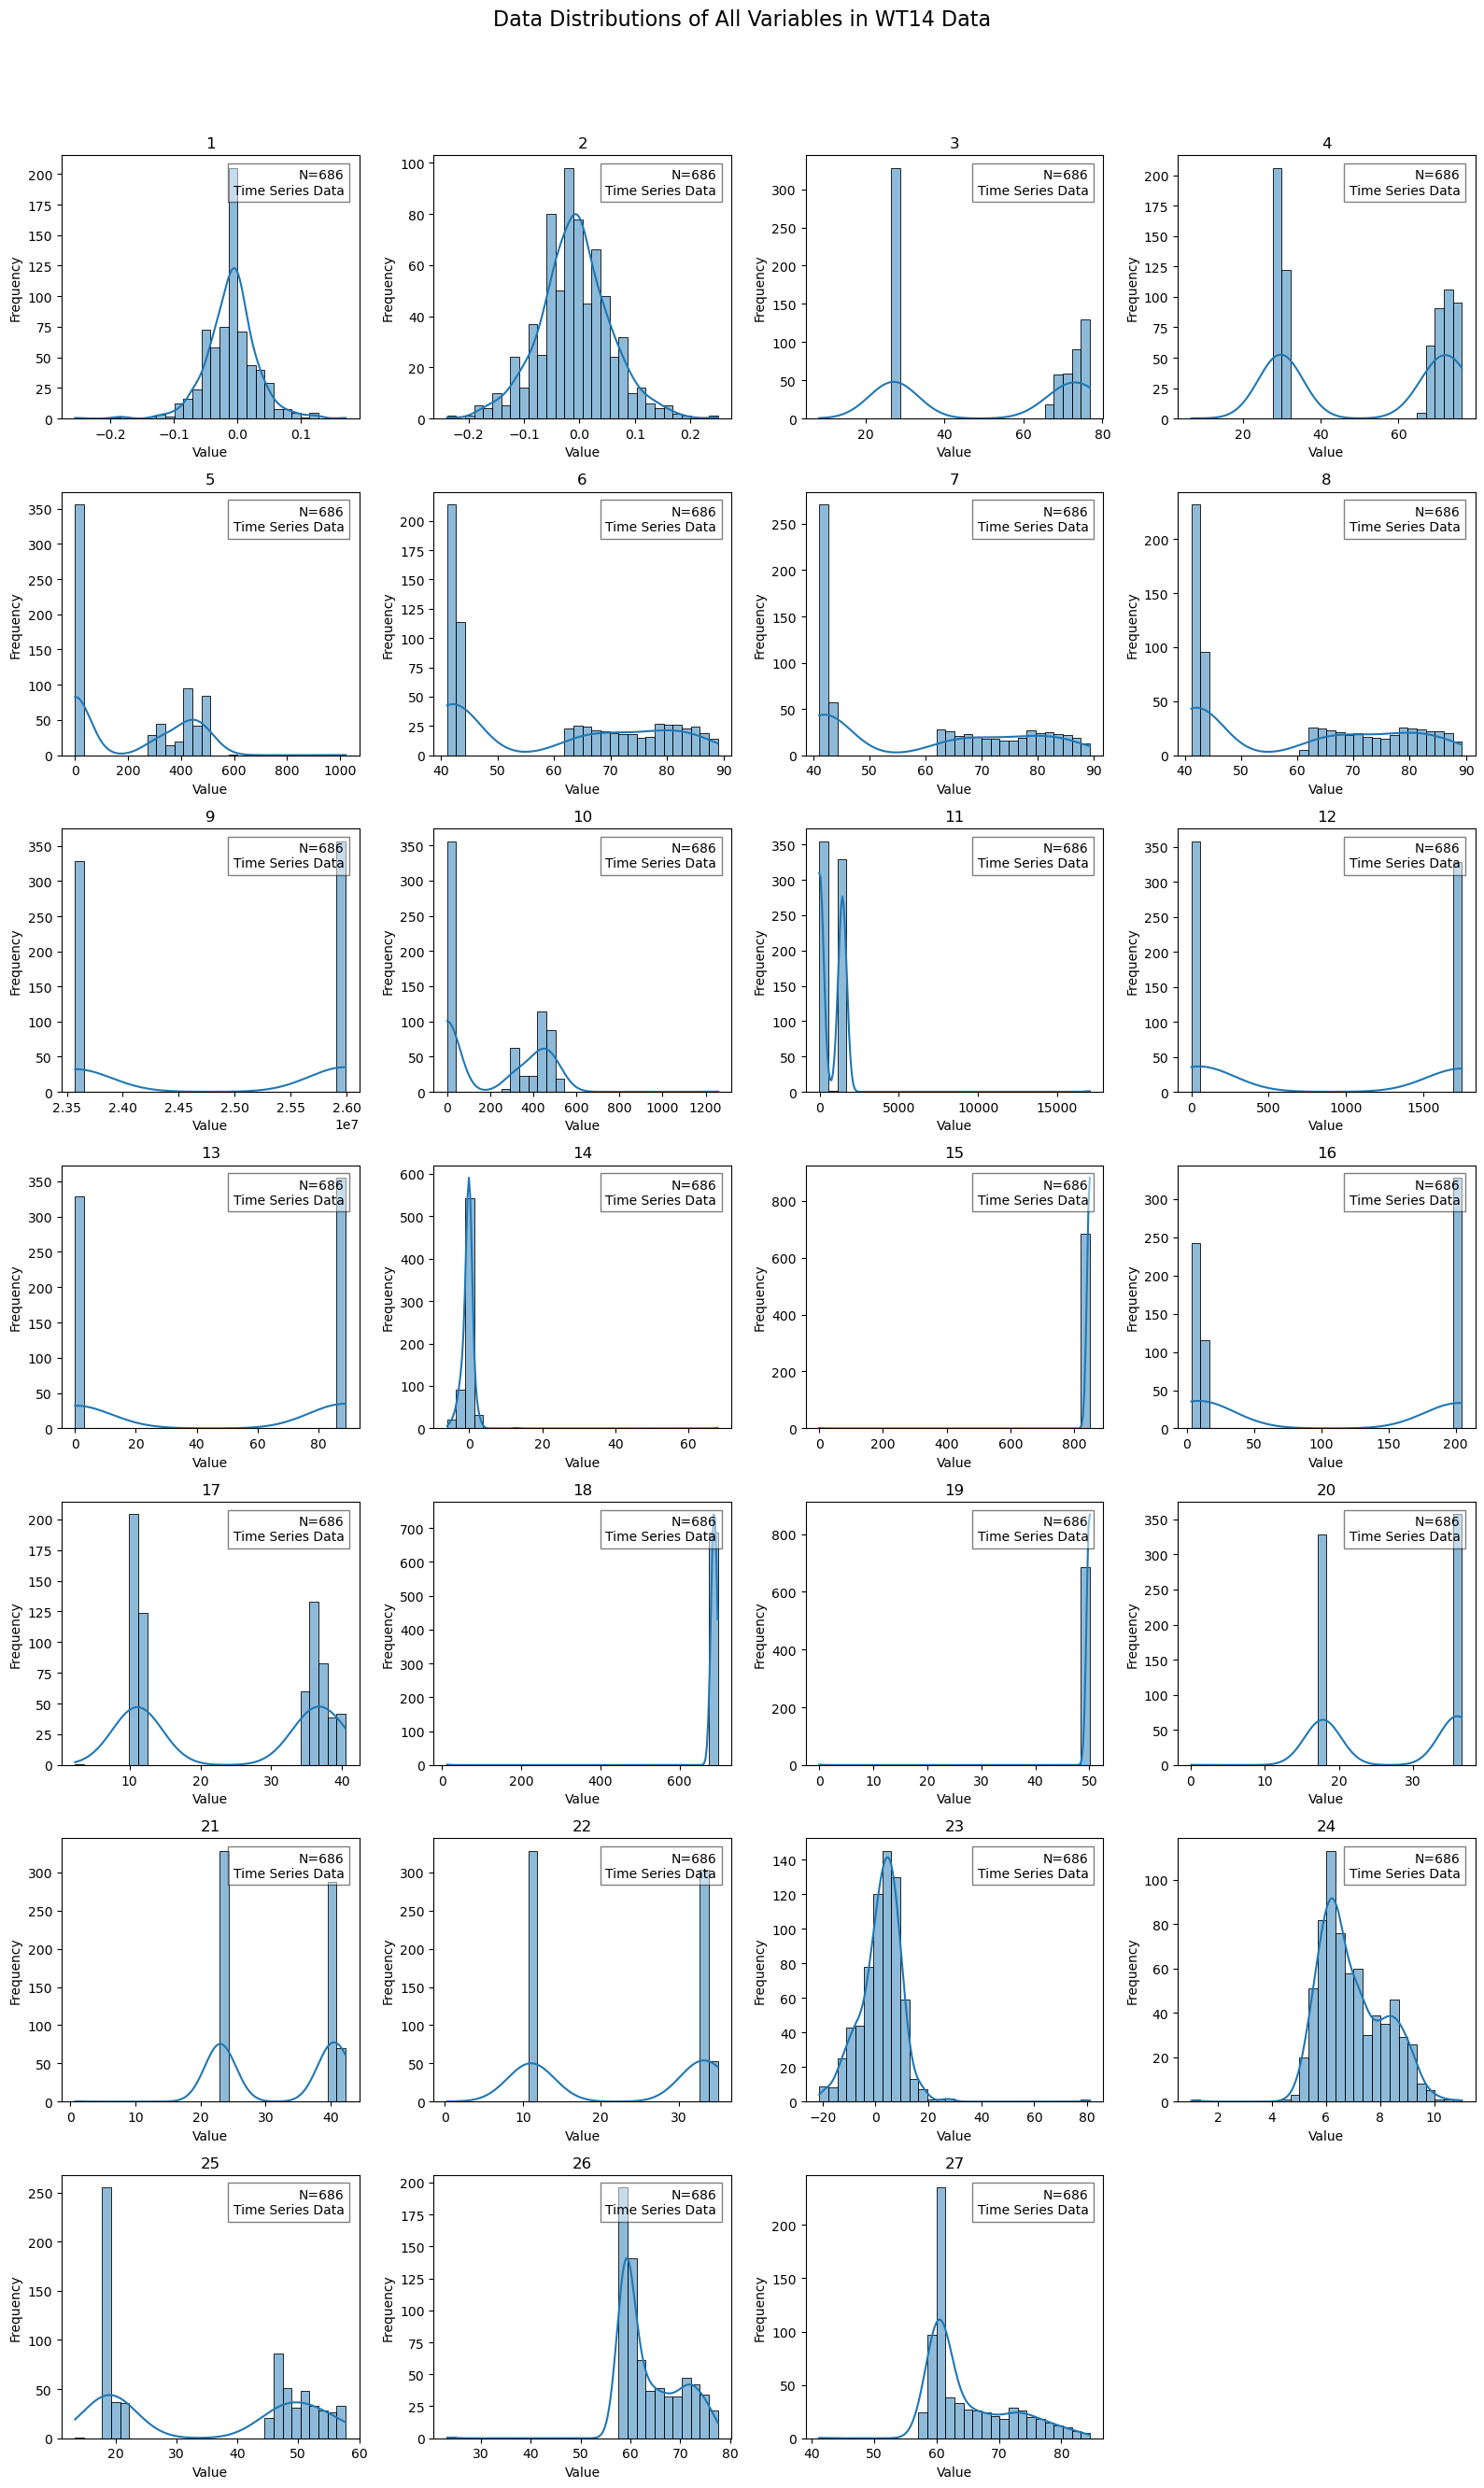

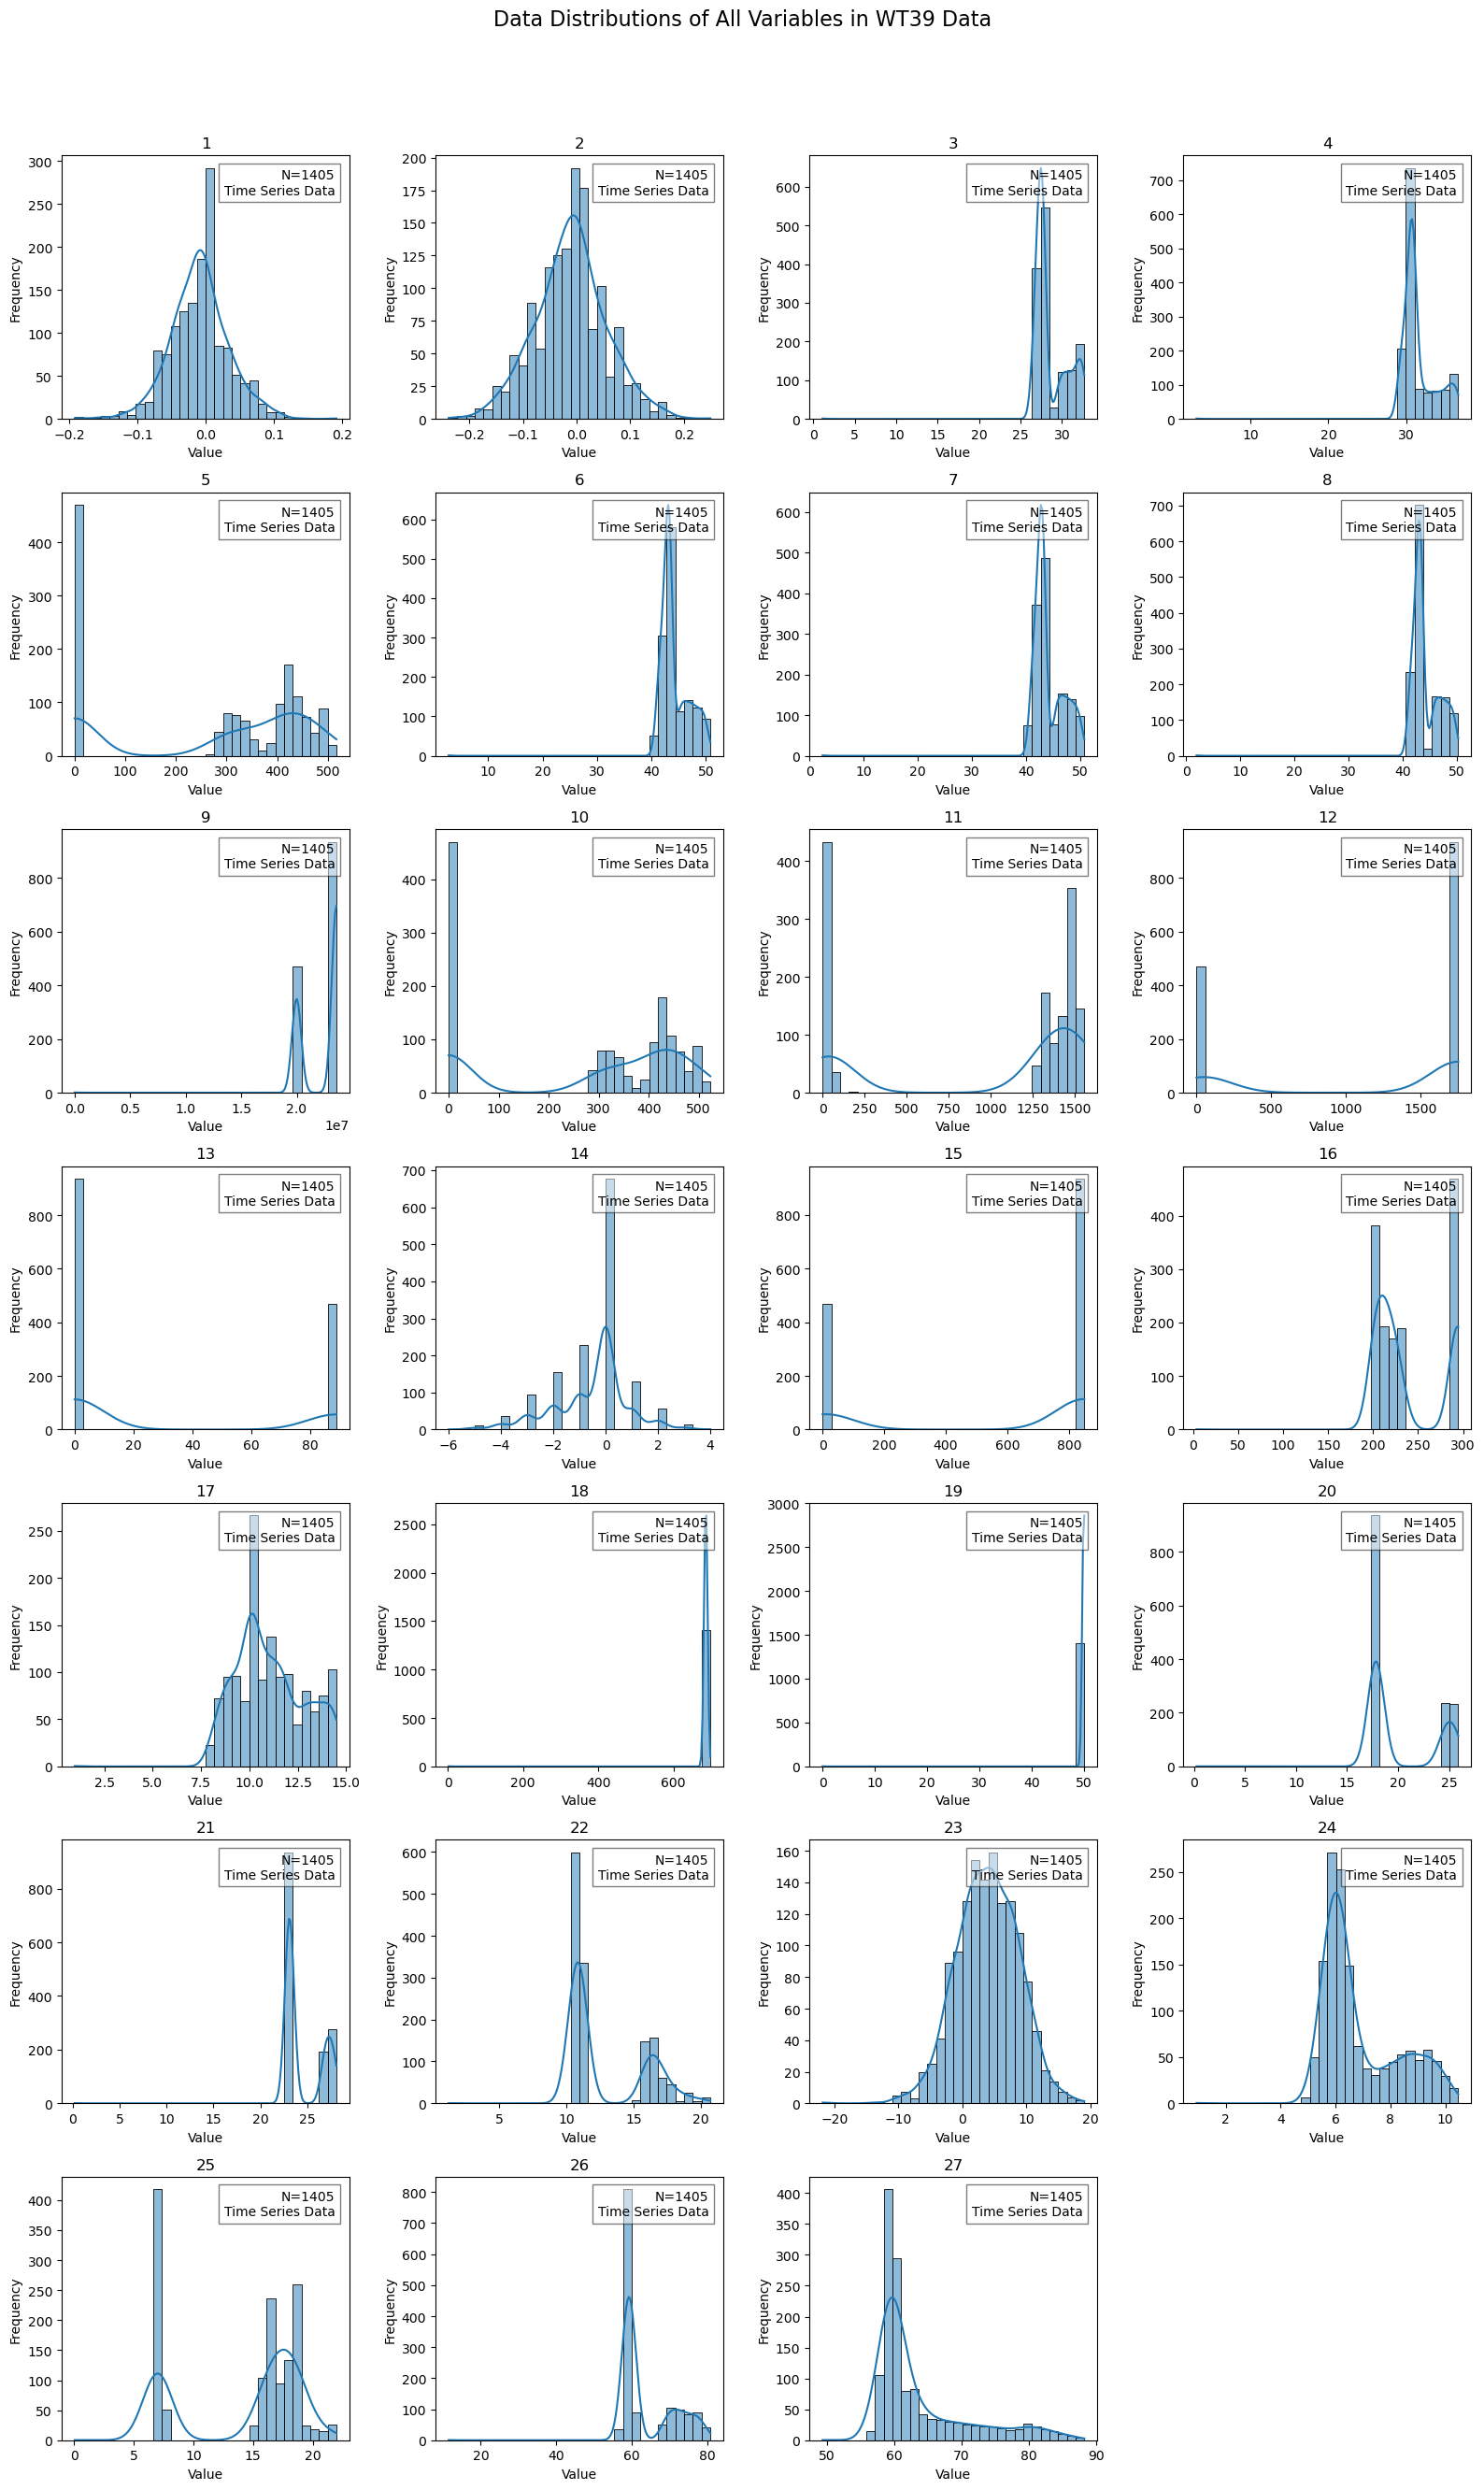

In [7]:
# Function to plot distributions of all variables with annotations
def plot_variable_distributions(data, title):
    num_vars = data.shape[1]  # Get number of variables
    num_rows = (num_vars + 3) // 4  # Calculate number of rows needed

    plt.figure(figsize=(16, num_rows * 4))  # Adjust figure size based on the number of rows

    # Number of observations
    num_observations = data.shape[0]

    # Loop through each variable and create a histogram
    for i, column in enumerate(data.columns):
        plt.subplot(num_rows, 4, i + 1)
        sns.histplot(data[column], bins=30, kde=True)  # KDE for a smooth density curve
        plt.title(column)
        plt.xlabel("Value")
        plt.ylabel("Frequency")

        # Add annotation for number of observations and time series note
        plt.text(0.95, 0.95, f'N={num_observations}\nTime Series Data', 
                 horizontalalignment='right', verticalalignment='top',
                 transform=plt.gca().transAxes, fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    plt.suptitle(f"Data Distributions of All Variables in {title}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.show()

# Call the function for each dataset
plot_variable_distributions(WT2_data, "WT2 Data")
plot_variable_distributions(WT14_data, "WT14 Data")
plot_variable_distributions(WT39_data, "WT39 Data")

The data shapes varies in terms of variables. Some have symmetric shape while other have very skewed shapes. We might have to consider some transformation technique before modelling the data in future.

### Variances of All the Variables in The Datasets 


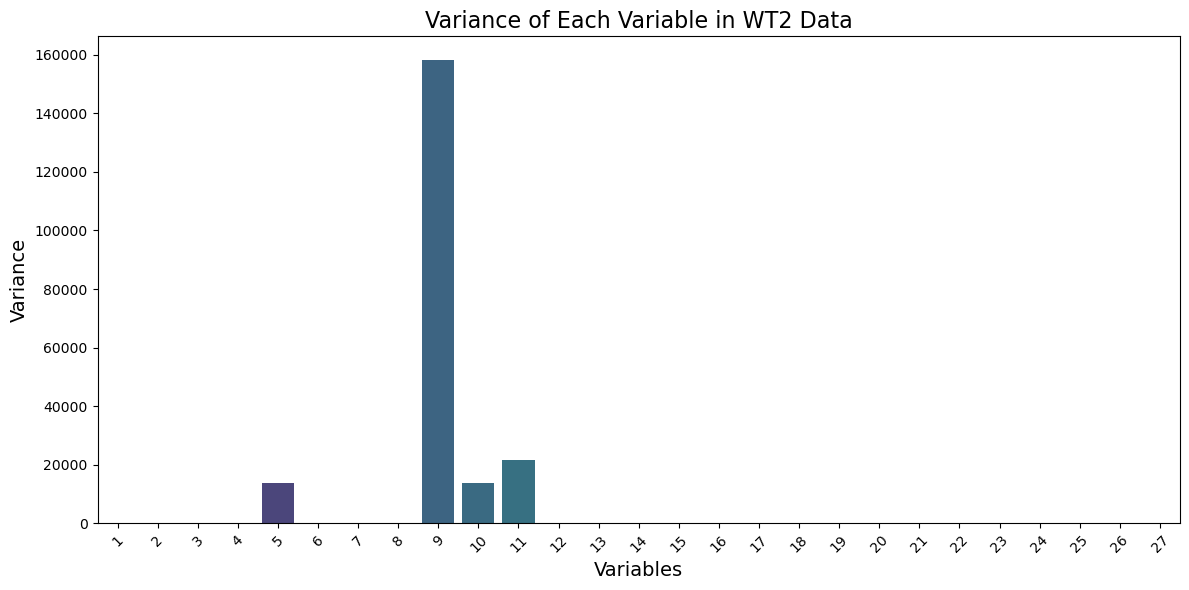

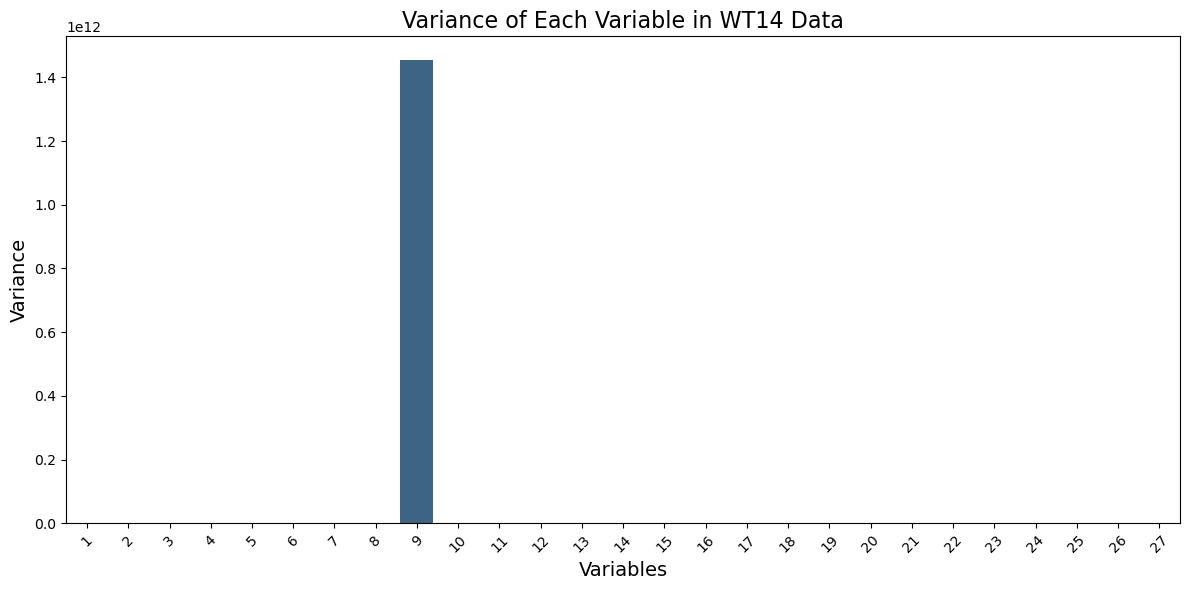

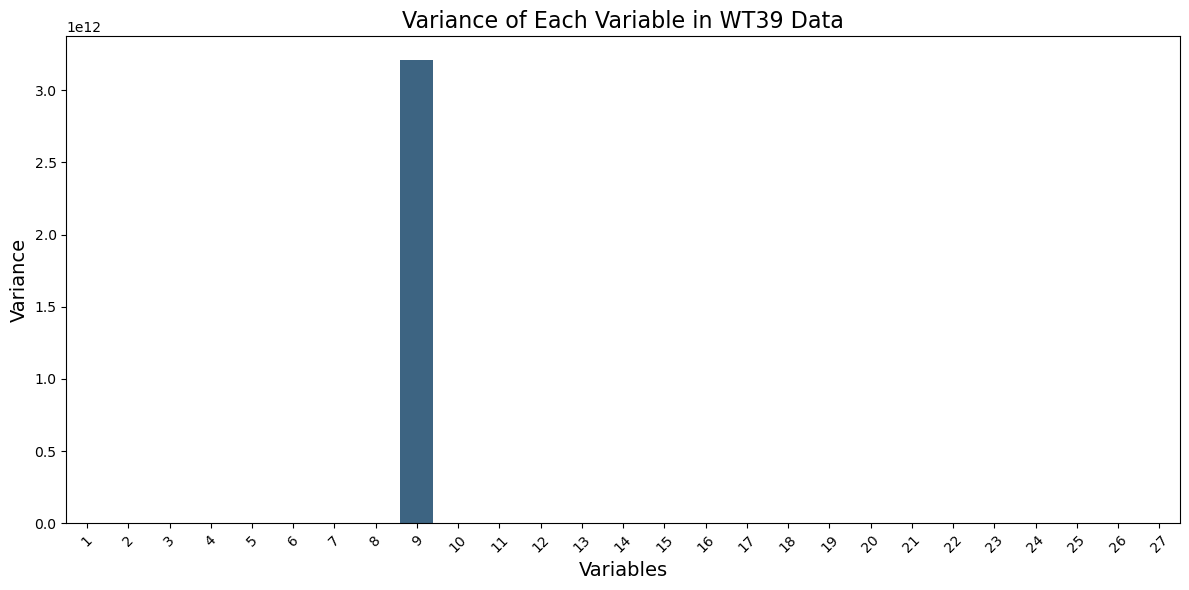

In [8]:
# Function to plot variance of each variable
def plot_variance(data, title):
    variances = data.var()  # Calculate variance for each column
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot for variances
    sns.barplot(x=variances.index, y=variances.values, palette='viridis')
    
    # Adding titles and labels
    plt.title(f"Variance of Each Variable in {title}", fontsize=16)
    plt.xlabel("Variables", fontsize=14)
    plt.ylabel("Variance", fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function for each dataset
plot_variance(WT2_data, "WT2 Data")
plot_variance(WT14_data, "WT14 Data")
plot_variance(WT39_data, "WT39 Data")


Interesting. Column 9 has the highest variance among all other variables in all three datasets !

## Data Pretreatment Plan

Before approaching our final goal of modelling, we will do the following preprocessing to the data

#### 1. **Identifying low variation features**
   - We need to drop the variables which have very low variation. 


#### 2. **Handling Missing Values**
   - We have seen that there is only one missing value in one of the faulty turbine dataset. We can impute the missing value with mean.

#### 3. **Normalization/Standardization and data transformation**
   - **Standardize Variables**: Given that PCA and PLS are sensitive to the scale of the data, standardize the features (z-score normalization) to have a mean of 0 and a standard deviation of 1.
   - We have noticed a wide variety or shapes in the data. So before modelling, we might want to transform those variables with log normal transformation or any other appropriate transformation.


#### 4. **Dimensionality Reduction (Optional)**
   - **Preliminary PCA**: Before proceeding to PLS, we will consider performing PCA on the datasets to visualize variance and correlations among variables.
   - **Select Principal Components**: Decide on the number of principal components to retain based on the explained variance ratio.

#### 5. **Feature Selection**
   - **Correlation Analysis**: Analyze the correlation matrix to identify highly correlated variables.
   - **Select Relevant Features**: For PLS modeling, select features that are most predictive of the target variable(s).
   - **Remove Redundant Features**: Eliminate highly correlated features if they do not contribute additional information.

#### 6. **Segmentation of Datasets**
   - **Create Target Variables**: For the healthy turbine, define the target sensor values for PLS modeling.
   - **Create Faulty Turbine Datasets**: Ensure that the first 20 observations of the two chosen faulty turbines are separated and properly labeled.



#### 7. **Data Splitting**
   - **Train/Test Split**: Before finalizing, we will consider splitting your healthy turbine data into training and testing sets for PLS modeling.
   - **Test set**: To assess model performance accurately.


## Data Pretreatment
At this point we will start the data pretreatment. First we will remove the variables which have very little variation. The following function will return the column names which have very less variation. The function works like this : 


- It calculates the variance for each column in the provided DataFrame.
- It then checks which columns have a variance below a specified threshold (0.01 in this case).
- It returns a list of these low variance column names.

### Identifying and dropping low variance columns

In [9]:
def identify_low_variance_columns(data, threshold=0.01):
    # Calculate variance for each column
    variances = data.var()
    # Identify columns with variance below the threshold
    low_variance_columns = variances[variances < threshold].index.tolist()
    return low_variance_columns

# Identify low variance columns for each dataset
low_variance_WT2 = identify_low_variance_columns(WT2_data)
low_variance_WT14 = identify_low_variance_columns(WT14_data)
low_variance_WT39 = identify_low_variance_columns(WT39_data)

# Print the results
print("Low variance columns in WT2 Data:", low_variance_WT2)
print("Low variance columns in WT14 Data:", low_variance_WT14)
print("Low variance columns in WT39 Data:", low_variance_WT39)


Low variance columns in WT2 Data: [1, 2, 12, 13, 15, 19]
Low variance columns in WT14 Data: [1, 2]
Low variance columns in WT39 Data: [1, 2]


We are seeing that column 1 and 2 are the common columns which have very low variation (less than 0.01). So we will drop these columns.

In [10]:


# Dropping columns 1 and 2 from the datasets
WT2_data_dropped = WT2_data.drop(columns=[WT2_data.columns[1], WT2_data.columns[2]])
WT14_data_dropped = WT14_data.drop(columns=[WT14_data.columns[1], WT14_data.columns[2]])
WT39_data_dropped = WT39_data.drop(columns=[WT39_data.columns[1], WT39_data.columns[2]])

# Display the shapes of the updated datasets
print("Shape of WT2 Data after dropping columns:", WT2_data_dropped.shape)
print("Shape of WT14 Data after dropping columns:", WT14_data_dropped.shape)
print("Shape of WT39 Data after dropping columns:", WT39_data_dropped.shape)


Shape of WT2 Data after dropping columns: (1570, 25)
Shape of WT14 Data after dropping columns: (686, 25)
Shape of WT39 Data after dropping columns: (1405, 25)


### Handling Missing Values
We had only one missing value in one the faulty turbines. We will fill it with mean

In [11]:
# Check missing values before filling
print("Missing values in WT14_data_dropped before filling:")
print(WT14_data_dropped.isnull().sum())

# Calculate the mean of column 9
mean_value = WT14_data_dropped[9].mean()  # Mean of column 9 using integer index

# Fill the missing value in column 9 with the mean
WT14_data_dropped[9].fillna(mean_value, inplace=True)

# Check missing values after filling
print("Missing values in WT14_data_dropped after filling with mean:")
print(WT14_data_dropped.isnull().sum())


Missing values in WT14_data_dropped before filling:
1     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
dtype: int64
Missing values in WT14_data_dropped after filling with mean:
1     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
dtype: int64


### Scaling The Datasets
We will now use Standard Scaler to standardize and scale the datasets. This is important before applying the PCA models. But before applying the PCA models, we have to seperate the first 20 observations from the faulty turbines as required in the task.

In [12]:
# Step 1: Separate the first 20 observations from WT14 and WT39
WT14_first20 = WT14_data_dropped.iloc[:20, :]
WT39_first20 = WT39_data_dropped.iloc[:20, :]

# Step 2: Standardize and scale each dataset
scaler = StandardScaler()

# For WT2_data_dropped (entire dataset)
WT2_scaled = scaler.fit_transform(WT2_data_dropped)

# For WT14_data_dropped (only first 20 observations)
WT14_scaled = scaler.fit_transform(WT14_first20)

# For WT39_data_dropped (only first 20 observations)
WT39_scaled = scaler.fit_transform(WT39_first20)



### PCA Models
Now we will apply the PCA models on these datasets

In [13]:
# Step 3: Apply PCA to each dataset
# PCA on WT2_data_dropped (Full Dataset)
pca_WT2 = PCA()
WT2_pca = pca_WT2.fit_transform(WT2_scaled)

# PCA on WT14_data_dropped (First 20 Observations)
pca_WT14 = PCA()
WT14_pca = pca_WT14.fit_transform(WT14_scaled)

# PCA on WT39_data_dropped (First 20 Observations)
pca_WT39 = PCA()
WT39_pca = pca_WT39.fit_transform(WT39_scaled)




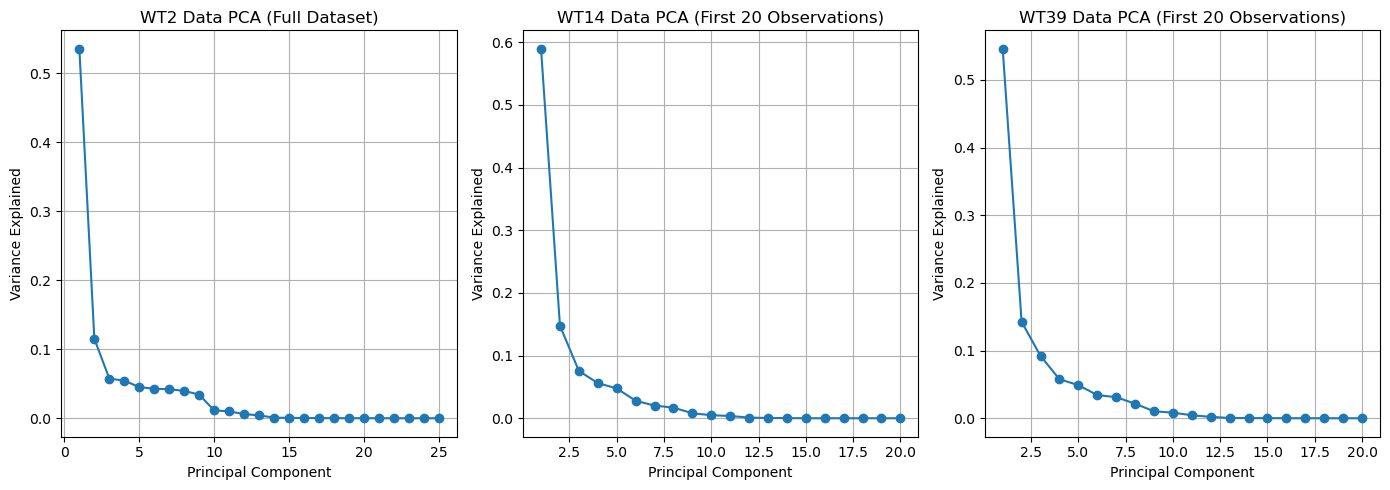

In [14]:
# Step 4: Visualize the explained variance ratio for each PCA model
plt.figure(figsize=(14, 5))

# Plot for WT2 PCA
plt.subplot(1, 3, 1)
plt.plot(range(1, len(pca_WT2.explained_variance_ratio_) + 1), pca_WT2.explained_variance_ratio_, marker='o')
plt.title('WT2 Data PCA (Full Dataset)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid()

# Plot for WT14 PCA
plt.subplot(1, 3, 2)
plt.plot(range(1, len(pca_WT14.explained_variance_ratio_) + 1), pca_WT14.explained_variance_ratio_, marker='o')
plt.title('WT14 Data PCA (First 20 Observations)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid()

# Plot for WT39 PCA
plt.subplot(1, 3, 3)
plt.plot(range(1, len(pca_WT39.explained_variance_ratio_) + 1), pca_WT39.explained_variance_ratio_, marker='o')
plt.title('WT39 Data PCA (First 20 Observations)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid()

# Show all plots
plt.tight_layout()
plt.show()

These plots are for explaining variance ratio against principal components, allowing us to observe which components capture most of the variance. As we can see 2 to 3 components can explain most of the variannce. Now we can show the PCA in 3D.

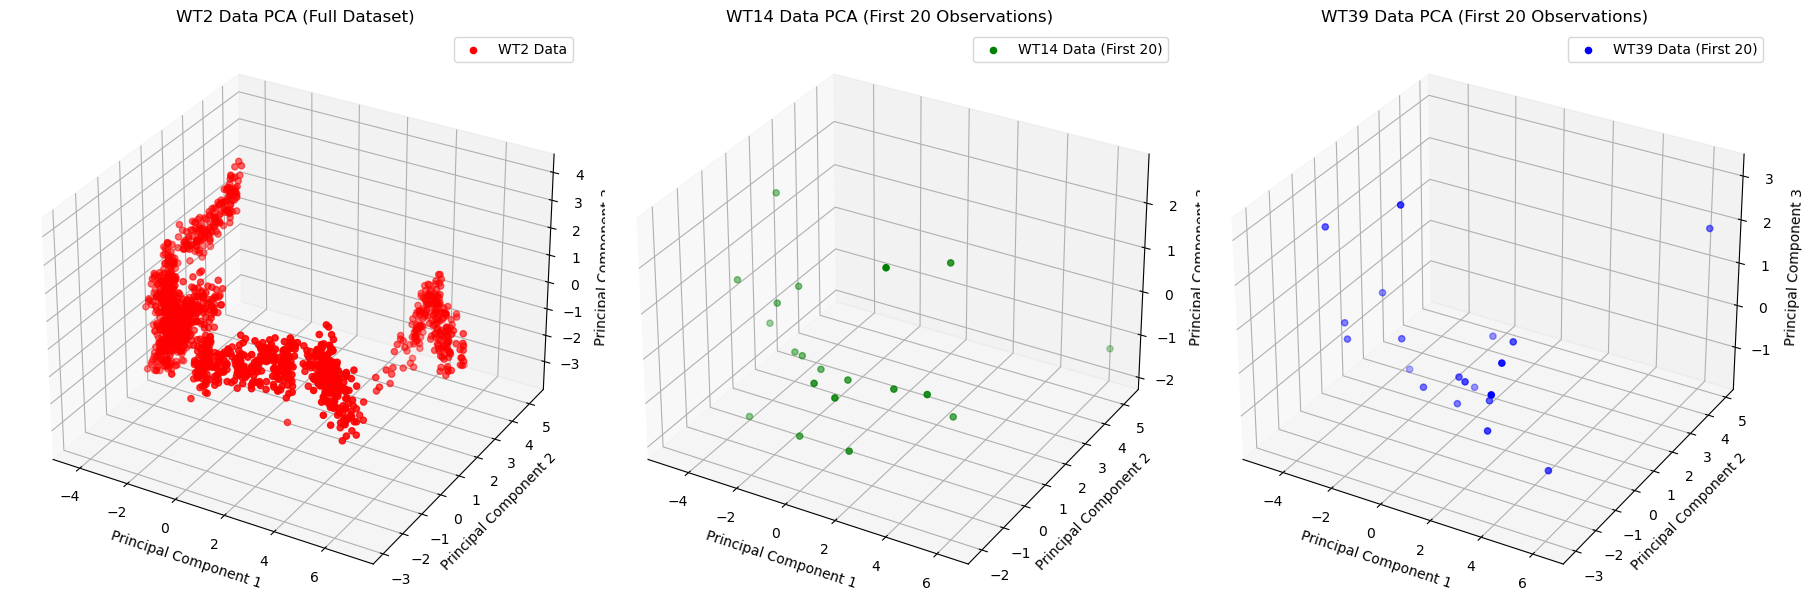

In [15]:
# Step 1: Refit PCA to use 3 components for visualization
pca_WT2 = PCA(n_components=3)
WT2_pca_3d = pca_WT2.fit_transform(WT2_scaled)

pca_WT14 = PCA(n_components=3)
WT14_pca_3d = pca_WT14.fit_transform(WT14_scaled)

pca_WT39 = PCA(n_components=3)
WT39_pca_3d = pca_WT39.fit_transform(WT39_scaled)

# Step 2: Create a 3D scatter plot for each dataset
fig = plt.figure(figsize=(18, 6))

# WT2 Data 3D PCA Visualization
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(WT2_pca_3d[:, 0], WT2_pca_3d[:, 1], WT2_pca_3d[:, 2], c='r', label='WT2 Data')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('WT2 Data PCA (Full Dataset)')
ax1.legend()

# WT14 Data 3D PCA Visualization (First 20 Observations)
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(WT14_pca_3d[:, 0], WT14_pca_3d[:, 1], WT14_pca_3d[:, 2], c='g', label='WT14 Data (First 20)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('WT14 Data PCA (First 20 Observations)')
ax2.legend()

# WT39 Data 3D PCA Visualization (First 20 Observations)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(WT39_pca_3d[:, 0], WT39_pca_3d[:, 1], WT39_pca_3d[:, 2], c='b', label='WT39 Data (First 20)')
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('WT39 Data PCA (First 20 Observations)')
ax3.legend()

# Step 3: Display the plots
plt.tight_layout()
plt.show()


### Visualizing the Loadings (Coefficients)
Now we will visualize the loadings of the sensors. Our goals are the following : 

- Look for sensors that have significantly different loadings between the healthy and faulty turbines.
- For instance, if a particular sensor has a high loading in the healthy turbine but a low (or negative) loading in the faulty turbine, it might indicate that this sensor is crucial for differentiating healthy vs. faulty states.

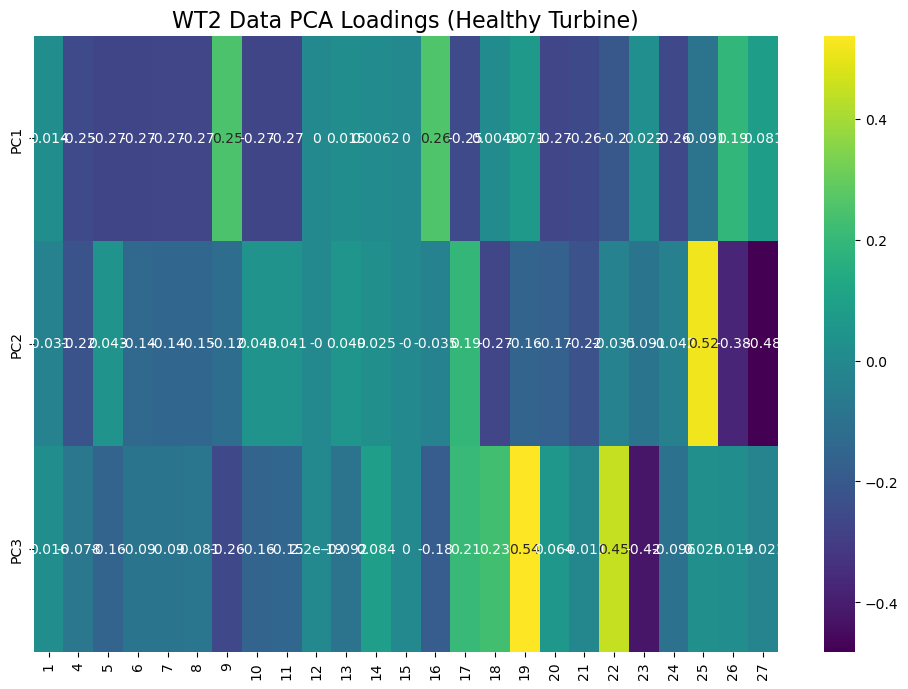

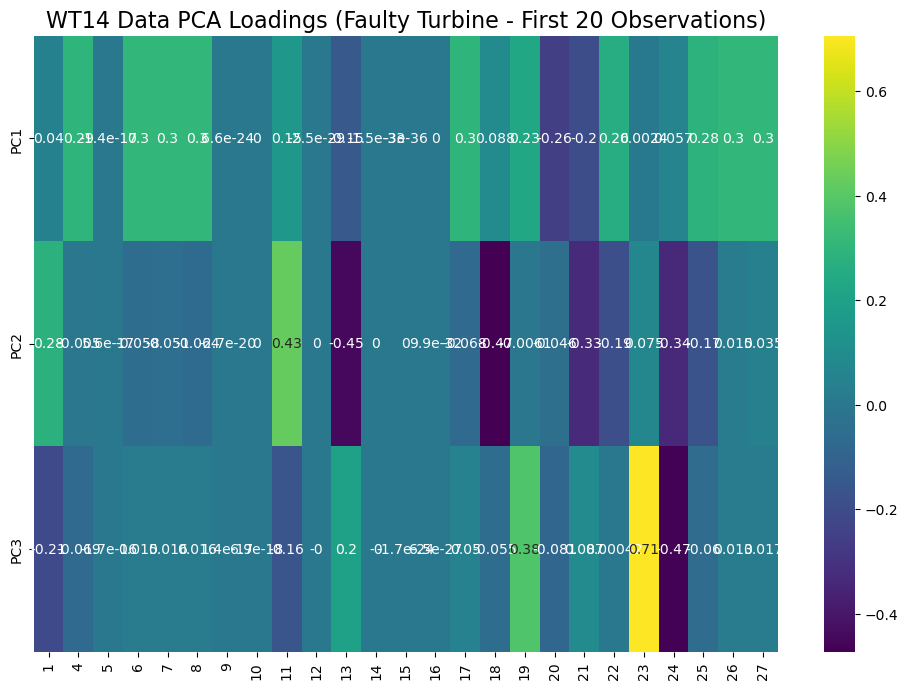

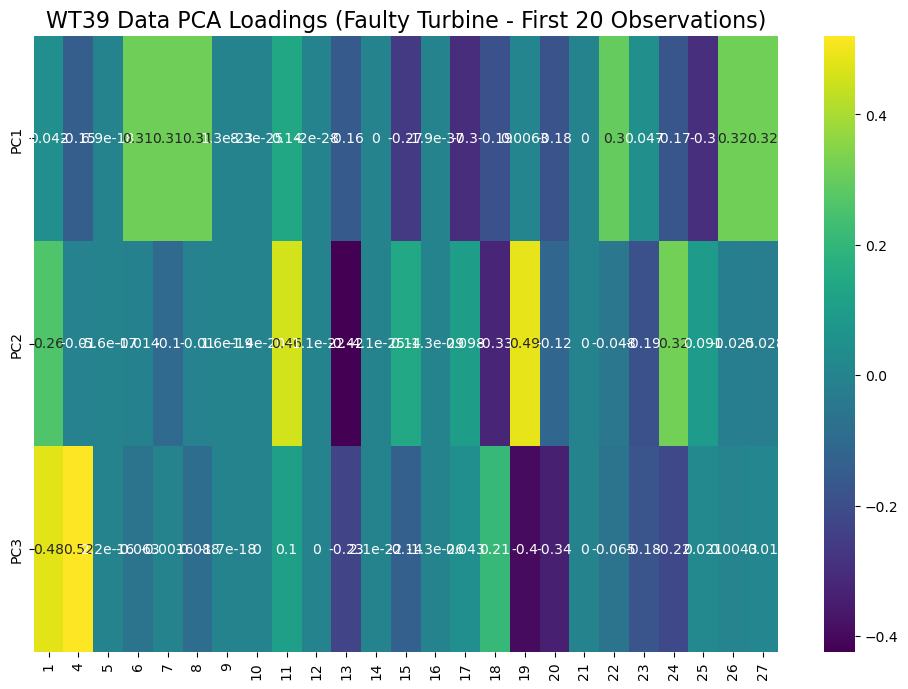

In [16]:
# Loadings DataFrames for each turbine's first three components
loadings_WT2 = pd.DataFrame(pca_WT2.components_[:3], columns=WT2_data_dropped.columns, index=[f'PC1', f'PC2', f'PC3'])
loadings_WT14 = pd.DataFrame(pca_WT14.components_[:3], columns=WT14_data_dropped.columns, index=[f'PC1', f'PC2', f'PC3'])
loadings_WT39 = pd.DataFrame(pca_WT39.components_[:3], columns=WT39_data_dropped.columns, index=[f'PC1', f'PC2', f'PC3'])

# Plot the loadings for each PCA separately
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_WT2, cmap='viridis', annot=True, cbar=True)
plt.title("WT2 Data PCA Loadings (Healthy Turbine)", fontsize=16)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(loadings_WT14, cmap='viridis', annot=True, cbar=True)
plt.title("WT14 Data PCA Loadings (Faulty Turbine - First 20 Observations)", fontsize=16)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(loadings_WT39, cmap='viridis', annot=True, cbar=True)
plt.title("WT39 Data PCA Loadings (Faulty Turbine - First 20 Observations)", fontsize=16)
plt.xticks(rotation=90)
plt.show()

### Compare the Loadings

Now we will compare the loadings of sensors from two different wind turbines (or turbine states) to identify which sensors have significant differences in their first principal component (PC1) loadings. This analysis can help in diagnosing potential issues or understanding the performance differences between the turbines.

In [17]:
def compare_significant_loadings(healthy_loadings, faulty_loadings, turbine_name, threshold=0.1):

    healthy_loadings = pd.Series(healthy_loadings.iloc[0])  # Use only PC1
    faulty_loadings = pd.Series(faulty_loadings.iloc[0])    # Use only PC1
    
    # Calculate absolute loading differences and directional change
    abs_loading_diff = abs(healthy_loadings - faulty_loadings)
    directional_change = np.sign(healthy_loadings) != np.sign(faulty_loadings)

    # Create a DataFrame to hold results
    diff_df = pd.DataFrame({
        'Healthy_Loading': healthy_loadings,
        f'{turbine_name}_Loading': faulty_loadings,
        'Absolute_Difference': abs_loading_diff,
        'Directional_Change': directional_change
    })
    
    # Filter for sensors with significant changes
    significant_sensors = diff_df[(diff_df['Absolute_Difference'] > threshold) | (diff_df['Directional_Change'])]
    
    # Get top 5 significant sensors
    top_5_significant_sensors = significant_sensors.nlargest(5, 'Absolute_Difference')

    return top_5_significant_sensors


top_5_WT14_significant = compare_significant_loadings(loadings_WT2, loadings_WT14, "WT14")
top_5_WT39_significant = compare_significant_loadings(loadings_WT2, loadings_WT39, "WT39")

print("Top 5 significant sensors for WT14:")
print(top_5_WT14_significant)

print("\nTop 5 significant sensors for WT39:")
print(top_5_WT39_significant)


Top 5 significant sensors for WT14:
    Healthy_Loading  WT14_Loading  Absolute_Difference  Directional_Change
6         -0.270502      0.304286             0.574788                True
7         -0.269905      0.303835             0.573740                True
8         -0.269755      0.303884             0.573640                True
4         -0.254271      0.294720             0.548991                True
17        -0.250900      0.295290             0.546189                True

Top 5 significant sensors for WT39:
    Healthy_Loading  WT39_Loading  Absolute_Difference  Directional_Change
6         -0.270502      0.313690             0.584192                True
7         -0.269905      0.312900             0.582805                True
8         -0.269755      0.310868             0.580624                True
22        -0.203643      0.296815             0.500459                True
11        -0.274211      0.137096             0.411307                True


## Modelling Plan 
Now our goal is to create PLS model on the healthy turbine data. Our objective is to predict the values of those 5 sensors and we can take faulty turbine data as the test data. As we can see that we have common sensors **6,7 and 8** identified in both of the faulty turbine but also there are sensor 4 and 17 in WT14 ; and sensor 22 and 11 in WT39 which we also have to predict. So we will basically have two models to predict sensor values for two faulty turbine.



### 1. Modelling Goal
**Purpose of Analysis:**
The primary objective of this analysis is to develop Partial Least Squares (PLS) regression models that predict the sensor values of key sensors (sensors 4, 6, 7, 8, 11, 17 and 22) for two different faulty turbines (WT14 and WT39) based on the data collected from a healthy turbine. This analysis aims to assess how effectively the healthy turbine data can be used to predict sensor performance in the presence of faults.

### 2. Model Training Strategy
**Tools Used:**
- **Python**: For data manipulation and analysis.
- **scikit-learn**: For implementing the PLS regression model.
- **Pandas**: For data handling and preprocessing.

**Methodology:**
1. **Data Preprocessing**: Clean and preprocess the healthy turbine data (WT2) to ensure it's suitable for model training. This includes handling missing values and normalization.
  
2. **Separate Target Sensors**:
   - For WT14, target sensors are **4, 6, 7, 8, 17**.
   - For WT39, target sensors are **6, 7, 8, 11, 22**.

3. **Feature Selection**: Identify and select the relevant input sensors that will serve as features for the PLS models, excluding the target sensors.

4. **Scaling**: Scale the input features to standardize the data, ensuring that all features contribute equally to the model.

5. **Model Training**:
   - Train two separate PLS regression models:
     - **Model 1**: Predict sensor values for WT14.
     - **Model 2**: Predict sensor values for WT39.

### 3. Model Validation Strategy
**Scope of Validation:**
- The validation will ensure that the models are generalizable and effective in predicting sensor values for the faulty turbines based on healthy turbine data.

**Methodology:**
1. **Cross-Validation**: Implement k-fold cross-validation on the training dataset to assess model performance and prevent overfitting.

2. **Hyperparameter Tuning**: Use techniques like Grid Search or Random Search to optimize hyperparameters for the PLS regression model.

3. **Performance Metrics**: Use metrics such as R-squared and Mean Squared Error (MSE) to evaluate model fit during validation.

4. **Comparison**: Compare model performance across different folds to ensure consistent results.

### 4. Model Testing Strategy
**Data Used:**
- The test datasets will be the corresponding data from WT14 and WT39, ensuring that they contain the same sensor features as those used in the training phase.

**Metrics:**
- **Mean Squared Error (MSE)**: To quantify the difference between predicted and actual sensor values.
- **R-squared (R²)**: To measure the proportion of variance in the target variable that is predictable from the input features.
- **Residual Analysis**: To visually assess the accuracy of the predictions through plots of residuals.

### 5. Description of the Mathematical Models Used
**Partial Least Squares Regression (PLS):**
- PLS regression is a statistical method that combines features from principal component analysis and multiple regression. It aims to find the fundamental relationships between two matrices (input features and output variables).
- The PLS algorithm works by projecting the original data into a new space defined by a set of latent variables (or components), which maximally correlate with the output variables. The key steps involve:
  - Extracting latent variables from the input features to capture the maximum variance.
  - Performing regression on the extracted latent variables to predict the target variables (sensor values).
- The model is beneficial in scenarios with highly collinear data and is particularly effective when the number of predictors is greater than the number of observations.

### Flowchart
Below is the revised textual representation of the flowchart, reflecting the changes regarding the separation of target sensors and the modeling process:

```
            Start: Clean Data
                   |
                   v
           Data Preprocessing
                   |
                   v
         Separate Target Sensors
                   |
                   v
          Feature Selection (input sensors)
                   |
                   v
              Data Scaling
                   |
                   v
                Model Training
                   |                \
                   v                 v
        Train PLS Model for       Train PLS Model for 
              WT14                        WT39
                   |                \
                   v                 v
            Model Validation (k-fold cross-validation, hyperparameter tuning)
                   |                \
                   v                 v
           Evaluate Performance     Evaluate Performance
                   |                \
                   v                 v
              Model Testing        Model Testing
                   |                \
                   v                 v
          Predict Sensor Values     Predict Sensor Values
                   |                \
                   v                 v
          Assess Prediction Quality  Assess Prediction Quality
                   |                \
                   v                 v
           End: Modeling Goal Achieved
```

